# IV Curve Seminar

In [1]:
from numpy import arange, exp, argmax
from math import factorial
from scipy.optimize import curve_fit
from matplotlib.pyplot import scatter, plot, show, legend, xlabel, ylabel, title
from scipy.constants import Boltzmann, elementary_charge
import pandas as pd

# Measurements

We put a 800 W halogen lamp on four solar cells, two in parallel and two in series. 

Each cell was about 6 V and 2.5 W.

The 2x2 cell array output had a resistive load $R$ of different values, made by a discrete resistor (22R) or series-parallel combinations. 

$R$ is the rated, not measured resistence, so we should consider the +/- 5% error.

In [2]:
d = pd.read_csv('iv_measurements.csv')
d

,L [cm],irrad [W/m^2],V [V],R [ohm],R error +,R error -
0,60,920,11.8,1000000,1050000.00,950000.00
1,60,920,10.6,34,38.85,35.15
2,60,920,10.5,25,26.25,23.75
3,60,920,10.1,22,23.10,20.90
4,60,920,5.9,12,12.60,11.40
5,60,920,3.1,6,6.30,5.70
6,60,920,2.1,4,4.20,3.80
7,60,920,1.6,3,3.15,2.85


Remove units for easier reading

In [3]:
d.columns = ['L', 'irrad', 'V', 'R', 'R+', 'R-']

Calculate current and power.

$ V = I\ R $ <br>

$ P = I\ V $

These could be called indirect measurements, with a simple measurement model (ohm's law):

In [4]:
d['I'] = d['V'] / d['R']
d['P'] = d['V'] * d['I']
d


,L,irrad,V,R,R+,R-,I,P
0,60,920,11.8,1000000,1050000.00,950000.00,0.000012,0.000139
1,60,920,10.6,34,38.85,35.15,0.311765,3.304706
2,60,920,10.5,25,26.25,23.75,0.420000,4.410000
3,60,920,10.1,22,23.10,20.90,0.459091,4.636818
4,60,920,5.9,12,12.60,11.40,0.491667,2.900833
5,60,920,3.1,6,6.30,5.70,0.516667,1.601667
6,60,920,2.1,4,4.20,3.80,0.525000,1.102500
7,60,920,1.6,3,3.15,2.85,0.533333,0.853333


However the error in knowing $R$ propogates into the indirect measurements of $I$ and $P$:

In [5]:
d['I+'] = d['V'] / d['R-']
d['I-'] = d['V'] / d['R+']
d['P+'] = d['V'] * d['I+']
d['P-'] = d['V'] * d['I-']
d

,L,irrad,V,R,R+,R-,I,P,I+,I-,P+,P-
0,60,920,11.8,1000000,1050000.00,950000.00,0.000012,0.000139,0.000012,0.000011,0.000147,0.000133
1,60,920,10.6,34,38.85,35.15,0.311765,3.304706,0.301565,0.272844,3.196586,2.892149
2,60,920,10.5,25,26.25,23.75,0.420000,4.410000,0.442105,0.400000,4.642105,4.200000
3,60,920,10.1,22,23.10,20.90,0.459091,4.636818,0.483254,0.437229,4.880861,4.416017
4,60,920,5.9,12,12.60,11.40,0.491667,2.900833,0.517544,0.468254,3.053509,2.762698
5,60,920,3.1,6,6.30,5.70,0.516667,1.601667,0.543860,0.492063,1.685965,1.525397
6,60,920,2.1,4,4.20,3.80,0.525000,1.102500,0.552632,0.500000,1.160526,1.050000
7,60,920,1.6,3,3.15,2.85,0.533333,0.853333,0.561404,0.507937,0.898246,0.812698


## Plot

Current vs voltage

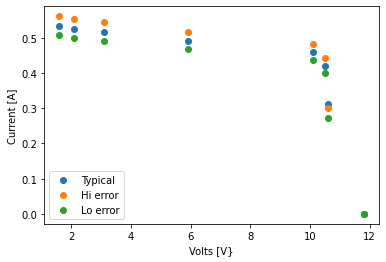

In [6]:
scatter(d['V'], d['I'], label='Typical')
scatter(d['V'], d['I+'], label='Hi error')
scatter(d['V'], d['I-'], label='Lo error')
legend()
xlabel('Volts [V}')
ylabel('Current [A]')
show()

Power vs voltage

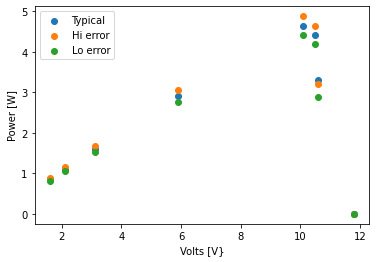

In [7]:
scatter(d['V'], d['P'], label='Typical')
scatter(d['V'], d['P+'], label='Hi error')
scatter(d['V'], d['P-'], label='Lo error')
legend()
xlabel('Volts [V}')
ylabel('Power [W]')
show()

Save these simply as $\bf V$ and $\bf I$ for later (both vectors).

In [8]:
V = d['V'].values 
I = d['I'].values 

# Curve fit

We know we'll need some constants.

In [9]:
n = 1.0					# ideality factor
k = Boltzmann 			# joules per kelvin
q = elementary_charge 	# couloumbs
T = 300.0 				# kelvin, about 27 C

## IV equation

The hat ($\ \hat{}\ $) symbol means estimated current, not measured.

There are many mathematical models (equations) to estimate the solar cell current from other inputs like irradiance or voltage. 

We will used the simplified expression from this [PV education article](https://www.pveducation.org/pvcdrom/solar-cell-operation/iv-curve#footnote1_zlgyr9m), note that $e^x$ is `exp(x)`.

$ \hat I (V) = I_L - I_S \ e^{ ( \frac{qV}{nkT} ) } $

In [10]:
def I_hat_eq(V, I_L, I_S):
	return I_L - I_S * ( exp(q*V / (n*k*T)) )

The above equation _should_ work.

But the python non-linear least squares algorithm is unable to calculate the covariance matrix when $e^x$ is involved. 

## IV equation with taylor expansion

So we need to do a taylor expansion of $e^x$, which is $e^x = 1 + \frac{x}{1!} + \frac{x^2}{2!} + \frac{x^3}{3!} ...$

or in pseudocode:

```
exp_taylor = 1 + x / factorial(1) + x^2 / factorial(2) + x^3 / factorial (3) ...
```

or with a loop:

```
i = 1
exp_taylor = 1
while i <= 3
    exp_taylor = exp_taylor + x^i / factorial(i)
    i++
```

In additon we'll use some python shorcuts:
- `x**2` is $x^2$ 
- `x+=1` is $x=x+1$
- `for x in range(1,4)` is _do the loop for_ $x = 1, 2, 3$ _(but not 4 because python)_


Our new equation is:

$ \hat I_t(V) = I_L - I_S \ \biggr( 1 + \frac{(\frac{qV}{nkT})}{1} + \frac{(\frac{qV}{nkT})^2}{2!} + \frac{(\frac{qV}{nkT})^3}{3!} + ... \biggr) $

Or more compact:

$ \hat I_t(V) = I_L - I_S \ \biggr( 1 + \sum_{i=1}^{\infty} { \frac{(\frac{qV}{nkT})^i}{i!} } \biggr) $ where rather than $\infty$ we will stop at 10.

In [11]:
def I_hat_eq(V, I_L, I_S):
	exp_taylor = 1
	for i in range(1,11): 								
		exp_taylor += (q*V / (n*k*T))**i/factorial(i)
	return I_L - I_S * exp_taylor	

## Fit

Make python fit (estimate) the parameters $I_L$ and $I_S$ in our function $\hat I_t(V)$.

In [12]:
(I_L, I_S), _ = curve_fit(I_hat_eq, V, I)

In [13]:
I_L

0.5276087579376828

In [14]:
I_S

4.663307455692037e-21

## Evalaute 

Try an analytical sanity check: when the voltage $V=0$, what is the estimated current $\hat I_t$ ? 

Is it close to what we measured for the not-quite-short-circuit current?

$\hat I_t(V) \biggr|_{0} = I_L - I_S \approx I_L = 0.533$ 

Yes that makes sense.

Now look at the values produced by our newly fit function:

In [15]:
d['I hat'] = I_hat_eq(V, I_L, I_S)
d[['I', 'V', 'I hat']]

,I,V,I hat
0,0.000012,11.8,0.011895
1,0.311765,10.6,0.350702
2,0.420000,10.5,0.366662
3,0.459091,10.1,0.418355
4,0.491667,5.9,0.527094
5,0.516667,3.1,0.527608
6,0.525000,2.1,0.527609
7,0.533333,1.6,0.527609


Before, we simply measured $V$ and indirectly measured $I$ with a simple measurement model. 

But now we have a fairly complex equation (model) with two "fit" parameters.

The model will estimate $\hat I$ for any value of $V$ we want (within reason, say, 0~12 V).

This is useful for interpolation, and finding the maximum power point.

## Plot

First calculate estimated currents (the curve) for a range of voltage values $v$:

In [16]:
v = arange(0.5, 12, .01)                
I_hat = I_hat_eq(v, I_L, I_S)

Then plot measurements and the curve (function, or model).

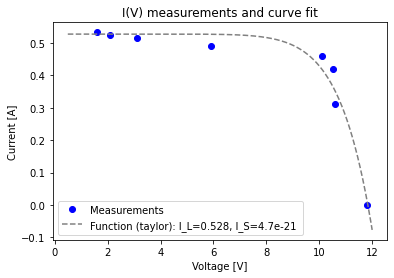

In [17]:
plot(V, I, 'o', color='blue', label='Measurements')
plot(v, I_hat, '--', color='gray', label=f'Function (taylor): I_L={I_L:.3f}, I_S={I_S:.1e} ')
xlabel('Voltage [V]')
ylabel('Current [A]')
title('I(V) measurements and curve fit')
legend()
show()

# Maximum power point

Since $P=IV$ we can quickly get $\hat P_t(V)$.

$ \hat P_t(V) = V \biggr ( I_L - I_S \ e^{ ( \frac{qV}{nkT} ) } \biggr ) = V \biggr ( I_L - I_S \ \biggr( 1 + \sum_{i=1}^{\infty} { \frac{(\frac{qV}{nkT})^i}{i!} } \biggr) \biggr ) $

In [18]:
def P_hat_eq(V, I_L, I_S):
	exp_taylor = 1
	for i in range(1,11): 								
		exp_taylor += (q*V / (n*k*T))**i/factorial(i)
	return V*(I_L - I_S * exp_taylor)

Analytically we could find where $\frac{ d \hat P_t }{dV}$ is minimum and solve for $V_{mpp}$. Maybe.

But this isn't a math class - we use computers.

Compute all the power values for a range of voltage values $v$:

In [19]:
v = arange(0.5, 12, .01) 
P_hat = P_hat_eq(v, I_L, I_S)

V_mpp = v[argmax(P_hat)]
P_max = max(P_hat)

In [20]:
V_mpp

9.300000000000008

In [21]:
P_max

4.460581406896795

Plot power

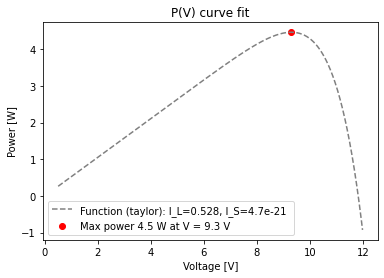

In [22]:
plot(v, P_hat, '--', color='gray', label=f'Function (taylor): I_L={I_L:.3f}, I_S={I_S:.1e} ')
scatter(V_mpp,  P_max, color='red', label=f'Max power {P_max:.1f} W at V = {V_mpp:.1f} V')
xlabel('Voltage [V]')
ylabel('Power [W]')
title('P(V) curve fit')
legend()
show()

Plot current

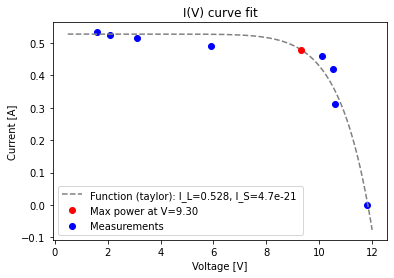

In [23]:
I_max = I_hat[argmax(P_hat)]

scatter(V,  I, color='blue', label=f'Measurements')
plot(v, I_hat, '--', color='gray', label=f'Function (taylor): I_L={I_L:.3f}, I_S={I_S:.1e} ')
plot(V_mpp,  I_max, 'o', color='red', label=f'Max power at V={V_mpp:.2f}')
xlabel('Voltage [V]')
ylabel('Current [A]')
title('I(V) curve fit')
legend()
show()

# Questions

Is the power as high as you would expect? 

What are the possible physical reasons for reduced max power?

Were we close to standard test conditions?

Could there be an inaccuracy due to the taylor expansion or current "measurement model"?